In [1]:
import numpy as np
%matplotlib inline
# %matplotlib notebook
# %matplotlib ipympl
# %matplotlib widget
#      widget, if installed and working, gives nicer inline plots
# %matplotlib nbagg
# Fix failing variable completion:
# %config Completer.use_jedi = False

# First, Simplest Usecase

Let's optimize a simple ellipsoid function, $\sum_{i=1}^n 1000^{\frac{i-1}{n-1}}x_i^2$, whose Hessian has a condition number of $10^6$:

In [3]:
from gp.gp_opt import GaussianProcessOptimization
import GPy
noise_var = 0.05 ** 2 # observation noise
beta = 2 # length of confidential bound
fmin = 0. # todo:add fmin or cancel it
bounds = [(-5., 10.), (0., 15.)]
kernel = GPy.kern.RBF(input_dim=len(bounds), variance=2., lengthscale=1.0, ARD=True)


In [11]:
import cma
from cma.purecma import CMAES

fun = cma.ff.branin  # we could use `functools.partial(cma.ff.elli, cond=1e4)` to change the condition number to 1e4
x0 = [0, 10]  # initial solution
sigma0 = 1    # initial standard deviation to sample new solutions

gp = GaussianProcessOptimization(GPy.models.GPRegression(np.asarray([x0]), np.asarray([[fun(x0)]]),
                                                         kernel=kernel, Y_metadata=None, normalizer=None,
                                                         noise_var=noise_var, mean_function=None),
                                 fmin, beta=beta)
gp.bounds = bounds

# es = cma.CMAEvolutionStrategy(x0,sigma0)
es = CMAES(x0, sigma0)
t = 0
while not es.stop():
    solutions = es.ask()
    obs = [fun(s) for s in solutions]
    gp.add_new_data_point(np.asarray(solutions), np.asarray(obs).reshape([-1,1]))
    # es.tell(solutions, obs)
    es.tell_gp(solutions, obs, gp)
    # if t % 10 == 0:
    es.disp()
    t+=1
# es.result_pretty()
print(es.result)

evals: ax-ratio max(std)   f-value
    6:     1.0  9.8e-01  71.94466350444418
   12:     1.0  9.5e-01  53.588450710263444
   18:     1.3  8.5e-01  50.932419212160674
   24:     1.3  9.6e-01  34.830381532059285
   30:     1.7  1.7e+00  22.33743307655704
   36:     1.7  1.8e+00  16.28046311258715
   42:     2.4  1.6e+00  19.650572325675746
   48:     2.4  1.6e+00  19.140983697804273
   54:     2.6  1.6e+00  17.623445564463246
evals: ax-ratio max(std)   f-value
   60:     2.6  1.5e+00  16.044856174927894
   66:     2.0  1.4e+00  15.40324005163781
   72:     2.0  1.2e+00  15.984095103274106
   78:     1.2  9.8e-01  16.16149770466761
   84:     1.2  1.3e+00  15.313482266246647
   90:     1.5  1.4e+00  13.84323717780183
   96:     1.5  1.2e+00  11.085085377459647
  102:     1.5  1.8e+00  6.89290846468086
  108:     1.5  1.7e+00  4.6648068490078245
  114:     2.1  2.3e+00  3.2671473904690718
evals: ax-ratio max(std)   f-value
  120:     2.1  1.9e+00  7.15336608481881
  126:     2.6  3.9e+00  

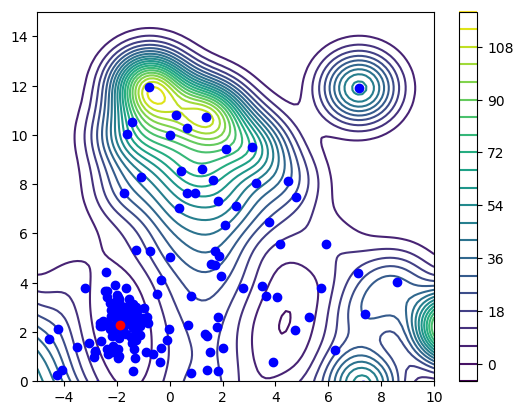

In [9]:
gp.plot(100, plot_3d=False)

The return values are
- `x`, the best evaluted solution and
- `es`, the `cma.CMAEvolutionStrategy` class instance used to run the optimization.

The latter contains all available information about the run and the more complete return value under `es.result`.

In [3]:
es.result

CMAEvolutionStrategyResult(xbest=array([-8.17430393e-09,  1.08551065e-09,  3.70388168e-11, -1.62210228e-11]), fbest=4.614929022700214e-16, evals_best=1337, evaluations=1337, iterations=167, xfavorite=array([-8.17430393e-09,  1.08551065e-09,  3.70388168e-11, -1.62210228e-11]), stds=array([2.87005084e-08, 2.17681179e-09, 3.14875038e-10, 2.95839704e-11]), stop={'tolfun': 1e-11})

# Options and Plotting
Let's plot some data from the optimization. The above call to `cma.fmin2` has (by default) written data to the default output folder `outcmaes`. These data will be overwritten each time the function is called again. To prevent this, we could set/change the output folder with the `verb_filenameprefix` option. An effective way to find out this kind of behavior is to query the CMA options with a search string and read the comments in the return "value".

In [5]:
cma.CMAOptions('file')

{'signals_filename': 'cma_signals.in  # read versatile options from this file (use `None` or `""` for no file) which contains a single options dict, e.g. ``{"timeout": 0}`` to stop, string-values are evaluated, e.g. "np.inf" is valid',
 'verb_append': '0  # initial evaluation counter, if append, do not overwrite output files',
 'verb_filenameprefix': 'outcmaes/  # output path and filenames prefix',
 'verb_log': '1  #v verbosity: write data to files every verb_log iteration, writing can be time critical on fast to evaluate functions'}

Plotting is as simple as

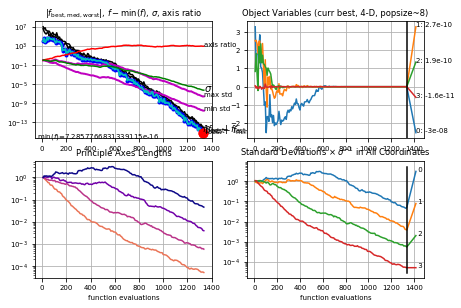

In [6]:
es.plot();  # cma.plot() does the same, as we just plot the data from the default output folder

A description of the output is given in the caption of Figure 3 in [Hansen et al (2015): Evolution Strategies](https://hal.inria.fr/hal-01155533/file/es-overview-2015.pdf#page=17).

# Options and Bound Constraints
We can add a boundary condition on any variable. We can find out how to do this, as mentioned above, by investigating the available boundary related options:

In [7]:
cma.CMAOptions('bound')  # returns options that contain "bound"

{'BoundaryHandler': 'BoundTransform  # or BoundPenalty, unused when ``bounds in (None, [None, None])``',
 'bounds': '[None, None]  # lower (=bounds[0]) and upper domain boundaries, each a scalar or a list/vector'}

Let's bound the second variable from below to values $\ge1$ using the `'bounds'` option. In this case, we must also take care that the initial solution is within the given bounds (it is, in our case). `'bounds'` is a list of two values, `[lower_bounds, upper_bounds]`, where `lower_bounds` and `upper_bounds` can be a scalar that applies to all variables or a list. If the list is shorter than the initial solution, the last value is applied to the remaining dimensions.

In [8]:
x, es = cma.fmin2(fun, x0, sigma0, {'bounds': [[None, 1, None], None]})

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=1023348, Tue Dec  7 13:20:44 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 5.707811623590359e+05 1.0e+00 9.49e-01  9e-01  1e+00 0:00.0
    2     16 1.176458458175318e+03 1.3e+00 1.30e+00  1e+00  1e+00 0:00.0
    3     24 1.662410371348872e+04 1.5e+00 1.23e+00  1e+00  1e+00 0:00.0
  100    800 1.000083503989450e+02 1.3e+03 1.86e-02  3e-05  3e-02 0:00.2
  192   1536 9.999999999999997e+01 8.6e+02 1.48e-06  7e-11  5e-08 0:00.3
termination on tolfun=1e-11 (Tue Dec  7 13:20:45 2021)
final/bestever f-value = 1.000000e+02 1.000000e+02
incumbent solution: [2.355520355231118e-08, 1.0, 1.5408677053447256e-10, 3.6448372302443525e-11]
std deviation: [5.0543644089260456e-08, 2.854661924954062e-09, 5.855566905947502e-10, 6.5589785335082e-11]


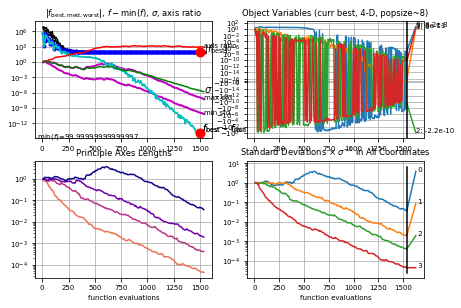

In [9]:
es.plot(xsemilog=True, x_opt=[0, 1] + (len(x0) - 2) * [0]);

Other [`notebooks and recipes`](https://github.com/CMA-ES/pycma/tree/master/notebooks), as this one, can be found at [https://github.com/CMA-ES/pycma/tree/master/notebooks](https://github.com/CMA-ES/pycma/tree/master/notebooks)

More `notebook-recipes` to come...